In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install transformers
!pip install mlxtend==0.17.0
#Installing the contractions library
!pip install contractions

     |████████████████████████████████| 2.1MB 8.1MB/s 
     |████████████████████████████████| 901kB 50.6MB/s 
     |████████████████████████████████| 3.3MB 54.6MB/s 
     |████████████████████████████████| 1.3MB 7.1MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
     |████████████████████████████████| 286kB 9.8MB/s 
     |████████████████████████████████| 327kB 14.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85395 sha256=85a51b5f80b8052e973ffa039b8cc16357189e7cd975d0bd154adec741a3985e
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [3]:
from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = TFAutoModel.from_pretrained("bert-base-uncased").bert

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pandas as pd
import numpy as np

df=pd.read_csv('/content/gdrive/MyDrive/FY_Project/OLIDv1.0/train_dataset.tsv',sep="\t")
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [6]:
df=df.loc[df["subtask_b"].notnull()]
df.reset_index(drop=True,inplace=True)
df=df.drop(['subtask_a', 'subtask_c'], axis=1)
df['subtask_b']=df['subtask_b'].apply(lambda x: 0 if x =='UNT' else 1)
df.head()

,id,tweet,subtask_b
0,86426,@USER She should ask a few native Americans wh...,0
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,62688,"@USER Someone should'veTaken"" this piece of sh...",0
3,97670,@USER Liberals are all Kookoo !!!,1
4,77444,@USER @USER Oh noes! Tough shit.,0


In [7]:
#importing required libraries
import nltk
import inflect
import contractions
from textblob import TextBlob 
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [8]:
# First function is used to denoise text
def denoise_text(text):
    # Strip html if any. For ex. removing <html>, <p> tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Replace contractions in the text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text
# Check the function 
sample_text = "<p>he didn't say anything </br> about what's gonna <html> happen in the climax"
denoise_text(sample_text)

'he did not say anything  about what is going to  happen in the climax'

In [9]:
import json
abbreviations_path="/content/gdrive/MyDrive/FY_Project/abbreviations_wordlist.json"
def cont_exp(x):
	abbreviations = json.load(open(abbreviations_path))

	if type(x) is str:
		for key in abbreviations:
			value = abbreviations[key]
			raw_text = r'\b' + key + r'\b'
			x = re.sub(raw_text, value, x)
			# print(raw_text,value, x)
		return x
	else:
		return x

cont_exp("project report complete asap. gn i am out lol")

'project report complete as soon as possible. good night i am out laughing out loud'

In [10]:
# Text normalization includes many steps.
# Each function below serves a step.

# Gets rid of the non ASCII characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# Converts the entire text to lowercase
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Removes the punctuation marks
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Numbers to their textual representation
def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

# Removes stop words
def remove_stopwords(words):
    new_words = []
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    for word in words:
        if word not in all_stopwords:
            new_words.append(word)
    return new_words

# Lemmatizes verbs in the list of tokenized words
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma)
    return lemmas

#All above functions are put together
def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    #words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    return words

In [11]:
# Downloading the necessary packages
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# Tokenize tweet into words
def tokenize(text):
    return nltk.word_tokenize(text)

#Text Preparation to use them into model
def text_prepare(text):
    text = denoise_text(text)
    text = cont_exp(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text

# check the function
sample_text = 'he didn\'t say anything!!!😊      about teachear    what is going to  happen #india. covid-19 patients are increasing expotentially?????? !!'

print("tokenize results :", tokenize(sample_text))
print("tokenize results :", text_prepare(sample_text))

tokenize results : ['he', 'did', "n't", 'say', 'anything', '!', '!', '!', '😊', 'about', 'teachear', 'what', 'is', 'going', 'to', 'happen', '#', 'india', '.', 'covid-19', 'patients', 'are', 'increasing', 'expotentially', '?', '?', '?', '?', '?', '?', '!', '!']
tokenize results : he did not say anything about teachear what is going to happen india covid19 patient are increasing expotentially


In [13]:
df['tweet'] = [text_prepare(x) for x in df['tweet']]

#Sample dataset after text_prepare
df.head()

,id,tweet,subtask_b
0,86426,user she should ask a few native american what...,0
1,90194,user user go home you are drunk user maga trum...,1
2,62688,user someone shouldvetaken this piece of shit ...,0
3,97670,user liberal are all kookoo,1
4,77444,user user oh no tough shit,0


In [14]:
#dfa represents the tweets with the targeted class
dfa=df[df["subtask_b"]==1]
#dfb represnts the tweets with the untargeted class
dfb=df[df["subtask_b"]==0]

#Upscaling
dfb=dfb.sample(n=int(0.9*dfa.shape[0]),replace=True,random_state=2)
df=pd.concat([dfa,dfb],axis=0)
df=df.reset_index(drop=True)
df.head()

,id,tweet,subtask_b
0,90194,user user go home you are drunk user maga trum...,1
1,97670,user liberal are all kookoo,1
2,52415,user wa literally just talking about this laug...,1
3,13384,user canada doe not need another cuck we alrea...,1
4,28414,user you are a lying corrupt traitor nobody wa...,1


In [15]:
# getting distribution of different sequence length in dateset
seqlen=df['tweet'].apply(lambda x:len(x.split()))

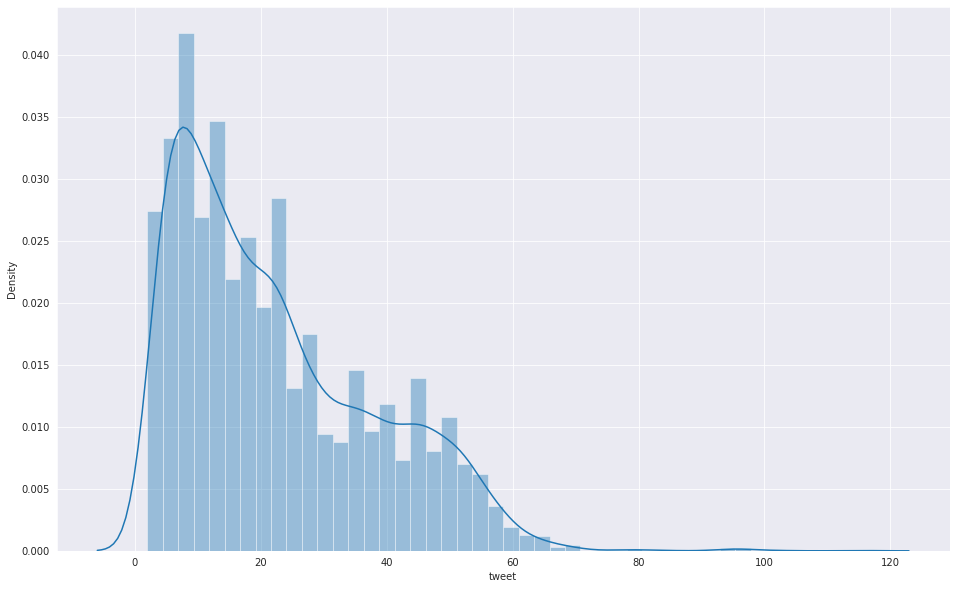

In [16]:
#plotting the distribution of seq length 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(16,10))
sns.distplot(seqlen)

In [17]:
from transformers import AutoTokenizer

SEQ_LEN = 50  # we will cut/pad our sequences to a length of 50 tokens

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# initialize two arrays for input tensors
Xids = np.zeros((len(df), SEQ_LEN))
Xmask = np.zeros((len(df), SEQ_LEN))

for i, sentence in enumerate(df['tweet']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

In [18]:
Xids,Xmask

(array([[  101.,  5310.,  5310., ...,     0.,     0.,     0.],
        [  101.,  5310.,  4314., ...,     0.,     0.,     0.],
        [  101.,  5310., 11333., ...,     0.,     0.,     0.],
        ...,
        [  101.,  5310.,  2045., ...,     0.,     0.,     0.],
        [  101.,  5310.,  5310., ...,  2032.,  1037.,   102.],
        [  101.,  5310.,  2667., ...,  2111.,  2079.,   102.]]),
 array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [19]:
from keras.utils import to_categorical
labels=to_categorical(df['subtask_b'])
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [20]:
import tensorflow as tf

BATCH_SIZE = 16  # we will use batches of 16

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
print(dataset)
# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# shuffle data and batch it
dataset = dataset.shuffle(100000).batch(BATCH_SIZE)
dataset

<TensorSliceDataset shapes: ((50,), (50,), (2,)), types: (tf.float64, tf.float64, tf.float32)>


<BatchDataset shapes: ({input_ids: (None, 50), attention_mask: (None, 50)}, (None, 2)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>

In [21]:
# get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])
SPLIT = 0.8  # 80-20 split

train = dataset.take(round(DS_LEN*SPLIT))  # get first 80% of batches
val = dataset.skip(round(DS_LEN*SPLIT))  # skip first 80% and keep final 20%

del dataset  # optionally, delete dataset to free up disk-space

In [22]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

# we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.LSTM(64)(embeddings)
X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X)

# define input and output layers of our model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the BERT layer - otherwise we will be training 100M+ parameters...
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 64)           213248      bert[0][0]                   

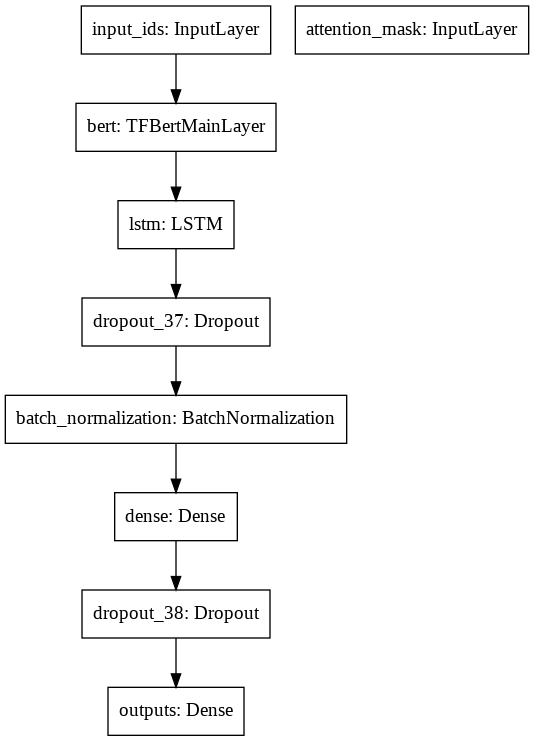

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model.png')

In [24]:
optimizer = tf.keras.optimizers.Adam(10e-5)
loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [25]:
history = model.fit(train, validation_data=val, epochs=10)

Epoch 1/10
369/369 [==============================] - 74s 92ms/step - loss: 0.8428 - accuracy: 0.5250 - val_loss: 0.6025 - val_accuracy: 0.6801
Epoch 2/10
369/369 [==============================] - 31s 85ms/step - loss: 0.7223 - accuracy: 0.6070 - val_loss: 0.5692 - val_accuracy: 0.7089
Epoch 3/10
369/369 [==============================] - 31s 85ms/step - loss: 0.6752 - accuracy: 0.6401 - val_loss: 0.5274 - val_accuracy: 0.7349
Epoch 4/10
369/369 [==============================] - 31s 84ms/step - loss: 0.6543 - accuracy: 0.6567 - val_loss: 0.4909 - val_accuracy: 0.7637
Epoch 5/10
369/369 [==============================] - 31s 84ms/step - loss: 0.6136 - accuracy: 0.6743 - val_loss: 0.4670 - val_accuracy: 0.7740
Epoch 6/10
369/369 [==============================] - 31s 84ms/step - loss: 0.5823 - accuracy: 0.7033 - val_loss: 0.4083 - val_accuracy: 0.8247
Epoch 7/10
369/369 [==============================] - 31s 85ms/step - loss: 0.5636 - accuracy: 0.7117 - val_loss: 0.3902 - val_accuracy:

In [26]:
score = model.evaluate(val)

92/92 [==============================] - 6s 65ms/step - loss: 0.3093 - accuracy: 0.8610


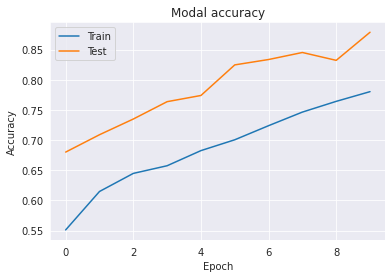

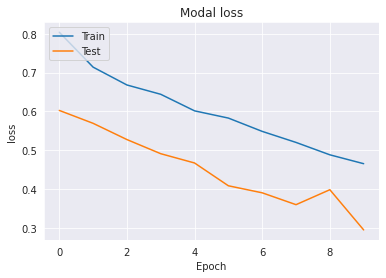

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modal accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modal loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

In [28]:
y_pred=[]
y_test=[]
for element in val:
  pred=model(element[0])
  y_pred.extend(np.argmax(pred, axis = 1))
  y_test.extend(np.argmax(element[1],axis=1))

In [29]:
len(y_pred),len(y_test)

(1460, 1460)

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8719178082191781

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


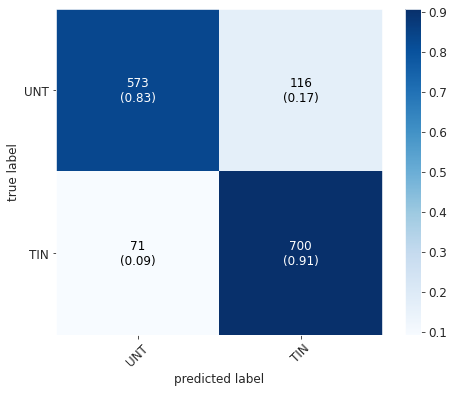

In [31]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib

class_names=['UNT','TIN']
font={
    'family':'Times New Roman',
    'size':12
}
matplotlib.rc('font',**font)
mat=confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=mat,figsize=(8,6),show_normed=True,colorbar=True,class_names=class_names)
plt.show()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         UNT       0.89      0.83      0.86       689
         TIN       0.86      0.91      0.88       771

    accuracy                           0.87      1460
   macro avg       0.87      0.87      0.87      1460
weighted avg       0.87      0.87      0.87      1460

